# Imports

In [1]:
from pathlib import Path
import sys
from datetime import datetime
import logging
import warnings
import time

abs_path = Path().resolve()
sys.path.append(str(abs_path.parent / "src" / "modules"))

from sklearn.linear_model import LinearRegression
import plotly.express as px

import ascii_atom
from files_funcs import *
from docx_funcs import *
from nlp_funcs import *
from ml_funcs import *
from timer_func import *
from eda_funcs import *


warnings.filterwarnings("ignore")

log_dir = abs_path / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
log_file = log_dir / f'{datetime.now().strftime("%Y-%m-%d")}.log'

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(log_file, mode='a', encoding='utf-8')
    ]
)

logger = logging.getLogger(__name__)

logger.info(ascii_atom.start)
logger.info(ascii_atom.cred)
logger.info("Inference started successfully.")

start_ = time.time()
logger.info("Timer started.\n")

c:\Users\yytrb\OneDrive\Рабочий стол\atom-compliance-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-10 08:22:41,686 - __main__ - INFO - 

  /$$$$$$                                    /$$ /$$                                               /$$      /$$ /$$             /$$$$$$$                                               /$$          
 /$$__  $$                                  | $$|__/                                              | $$$    /$$$| $$            | $$__  $$                                             | $$          
| $$  \__/  /$$$$$$  /$$$$$$/$$$$   /$$$$$$ | $$ /$$  /$$$$$$  /$$$$$$$   /$$$$$$$  /$$$$$$       | $$$$  /$$$$| $$            | $$  \ $$ /$$$$$$   /$$$$$$  /$$  /$$$$$$   /$$$$$$$ /$$$$$$        
| $$       /$$__  $$| $$_  $$_  $$ /$$__  $$| $$| $$ |____  $$| $$__  $$ /$$__

# Config

In [2]:
main_dir = abs_path.parent

config_path = main_dir / "config" / "config.yaml"
config = load_yaml(config_path)

data_dir = abs_path.parent / "data"
uc_data_dir = data_dir / "test_data" / "HMI"
ssts_data_dir = data_dir / "test_data" / "SSTS"

model_dir = main_dir / "models"

columns = (
        config["ds_topology"]["main_columns"]
        + list(set(config["ds_topology"]["hmi_subheaders"].values()))
        + config["ds_topology"]["targets"]
)
columns = [col.lower().replace(" ", "_") for col in columns]

text_cols = [f'{col}' for col in set(config["ds_topology"]["hmi_subheaders"].values())]
text_cols = text_cols + ["differences"]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logger.info(f'Device: {DEVICE}')

2024-11-10 08:22:41,712 - __main__ - INFO - Device: cpu


# Data Loading

In [3]:
ds = create_ds(uc_data_dir, ssts_data_dir, columns)
logger.info("Data loaded.")

ds

Warning! [Errno 2] No such file or directory: 'C:\\Users\\yytrb\\OneDrive\\Рабочий стол\\atom-compliance-ml\\data\\test_data\\SSTS\\SSTS-26160.docx'


2024-11-10 08:22:42,150 - __main__ - INFO - Data loaded.


,id,case_name,full_uc_text,full_ssts_text,goal,postconditions,preconditions,other,main_scenario,differences,description,complience_level
0,8800,Receiving Call Notifications,[I-8800] Receiving Call Notifications\nPrecon...,Receiving Call Notifications\nFunctional Descr...,,"Postconditions:\nIf the call is accepted, the ...",Preconditions\nEntertainment system is ready. ...,,Main Scenario:\nAn incoming call is received o...,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,None
1,6583,Driver initiate a call through SWP,[I-6583] Driver initiate a call through SWP\n...,Make a call (B sample)\nFunctional Description...,,Postconditions:\nIf the call is initiated succ...,Preconditions:\nThe IVI is on in_2 \nThe vehic...,,Main Scenario:\nThe driver navigates to the 'C...,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,None
2,26160,Filtering the internet radio stations,[I-26160] Filtering the internet radio statio...,None,Goal: 'Reorder the Internet Radio stations by ...,Postconditions:\nout_2/out_5 displays the inte...,Preconditions:\nATOM is connected to the inter...,Description: Requirenments:\nThe action is dis...,Main Scenario:\nout_2/out_5 displays the list ...,Next words are missing in UC-text:\n- [I-26160...,Next words are missing in SSTS-text:\n,None
3,31523,Adding Internet Radio to Favorites List,[I-31523] Adding Internet Radio to Favorites ...,Favorite Song operation\nFunctional Descriptio...,Goal: User wants to add favorites internet rad...,Postconditions:\nThe selected internet radio s...,Preconditions:\nUser in in the Internet Radio ...,Description: Actors:\nCar User \nIVI Triggers:...,Main Scenario:\nThe user press on the UI inter...,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,None
4,26161,FM Radio Stations switching,[I-26161] FM Radio Stations switching\nDescri...,Automatic search\nFunctional Description\nSupp...,,Postconditions:\nout_5/out_2 shows the station...,Preconditions:\nUser has selected FM Radio pla...,Description: Requirenments:\nThe action is dis...,Main Scenario:\nUser presses the forward/backw...,Next words are missing in UC-text:\n- [I-26161...,Next words are missing in SSTS-text:\n Automat...,None
5,30371,ERA Self-diagnosis,[I-30371] ERA Self-diagnosis\nActors:\nERA-Gl...,ERA Self-diagnosis\nFunctional Description\n\n...,,,,Description:\nERA self-diagnosis whether the s...,,Next words are missing in UC-text:\n- [I-30371...,Next words are missing in SSTS-text:\n Functio...,None
6,26771,Turn on and off hotspot via VA,[I-26771] Turn on and off hotspot via VA\n\nD...,\nTurn on and off hotspot\nFunctional Descript...,Goal: \nUsers can turn on or off the vehicle h...,,,Description: Scope:\nSWP Android \nVA \nSmartp...,Main scenario:\nThe user asks in_24 Voice. Mic...,Next words are missing in UC-text:\n- [I-26771...,Next words are missing in SSTS-text:\n Functio...,None
7,28561,Setting Hotspot name & password,[I-28561] Setting Hotspot name & password\nUs...,hotspot settings\nFunctional Description\nUser...,Goal:\nUsers can modify the name and password ...,,,Scope: \nSWP Actors:\nDriver \nOwner Requireme...,Main Scenario:\nThe user guides to the hotspot...,Next words are missing in UC-text:\n- [I-28561...,Next words are missing in SSTS-text:\n hotspot...,None
8,8692,Emergency Service Communication (ERA-Glonass),[I-8692] Emergency Service Communication (ERA...,Manual dialing E-CALL\nFunctional Description\...,,Postconditions：\nThe driver is able to communi...,Preconditions:\nThe vehicle is in the Drive St...,Trigger:\nThe vehicle sensors detect a collisi...,Main Scenario:\nThe ERA-Glonass initiates emer...,Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,None
9,8604,Source selection for Media output,[I-8604] Source selection for Media output\nD...,Switch music sources\nFunctional Description\n...,Goal: Enab

# Models Loading

## BERT

In [4]:
bert_model = (
    BertModel
    .from_pretrained(config["bert"], output_hidden_states=True)
    .to(DEVICE)
)
tokenizer = BertTokenizer.from_pretrained(config["bert"])

logger.info(bert_model)
logger.info(tokenizer)

2024-11-10 08:22:44,071 - __main__ - INFO - BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

## Developed ML Model

In [5]:
model_path = model_dir / create_model_name(LinearRegression())

model = pickle_to_obj(model_path)

logger.info(f'Developed ML Model loaded: {model}')
model

2024-11-10 08:22:44,101 - __main__ - INFO - Developed ML Model loaded: LinearRegression()


LinearRegression()

# Proccessing & prediction

In [6]:
ssts_texts = pd.DataFrame(ds["full_ssts_text"]).fillna("EMPTY")
ssts_texts_vectorized = extract_text_vectors(
    ssts_texts,
    "full_ssts_text",
    bert_model,
    tokenizer,
    DEVICE,
    verbose=False
).drop("full_ssts_text", axis=1)

for col in text_cols:
    ds[f'f_{col}'] = get_pairwise_dist_with_ssts(
        ds[col],
        ssts_texts_vectorized,
        config["distance_metric"],
        bert_model=bert_model,
        tokenizer=tokenizer,
        device=DEVICE,
        verbose=False
    )

logger.info("Dataset processed.")
ds

2024-11-10 08:22:58,001 - __main__ - INFO - Dataset processed.


,id,case_name,full_uc_text,full_ssts_text,goal,postconditions,preconditions,other,main_scenario,differences,description,complience_level,f_goal,f_postconditions,f_preconditions,f_other,f_main_scenario,f_differences
0,8800,Receiving Call Notifications,[I-8800] Receiving Call Notifications\nPrecon...,Receiving Call Notifications\nFunctional Descr...,,"Postconditions:\nIf the call is accepted, the ...",Preconditions\nEntertainment system is ready. ...,,Main Scenario:\nAn incoming call is received o...,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,None,0.707159,0.089409,0.201947,0.707159,0.096076,0.250389
1,6583,Driver initiate a call through SWP,[I-6583] Driver initiate a call through SWP\n...,Make a call (B sample)\nFunctional Description...,,Postconditions:\nIf the call is initiated succ...,Preconditions:\nThe IVI is on in_2 \nThe vehic...,,Main Scenario:\nThe driver navigates to the 'C...,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,None,0.700773,0.142870,0.116366,0.700773,0.085319,0.212110
2,26160,Filtering the internet radio stations,[I-26160] Filtering the internet radio statio...,None,Goal: 'Reorder the Internet Radio stations by ...,Postconditions:\nout_2/out_5 displays the inte...,Preconditions:\nATOM is connected to the inter...,Description: Requirenments:\nThe action is dis...,Main Scenario:\nout_2/out_5 displays the list ...,Next words are missing in UC-text:\n- [I-26160...,Next words are missing in SSTS-text:\n,None,0.671908,0.685351,0.697113,0.705944,0.592166,0.751206
3,31523,Adding Internet Radio to Favorites List,[I-31523] Adding Internet Radio to Favorites ...,Favorite Song operation\nFunctional Descriptio...,Goal: User wants to add favorites internet rad...,Postconditions:\nThe selected internet radio s...,Preconditions:\nUser in in the Internet Radio ...,Description: Actors:\nCar User \nIVI Triggers:...,Main Scenario:\nThe user press on the UI inter...,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,None,0.244862,0.229658,0.286855,0.121353,0.222321,0.224094
4,26161,FM Radio Stations switching,[I-26161] FM Radio Stations switching\nDescri...,Automatic search\nFunctional Description\nSupp...,,Postconditions:\nout_5/out_2 shows the station...,Preconditions:\nUser has selected FM Radio pla...,Description: Requirenments:\nThe action is dis...,Main Scenario:\nUser presses the forward/backw...,Next words are missing in UC-text:\n- [I-26161...,Next words are missing in SSTS-text:\n Automat...,None,0.725531,0.212765,0.235335,0.319827,0.189623,0.236090
5,30371,ERA Self-diagnosis,[I-30371] ERA Self-diagnosis\nActors:\nERA-Gl...,ERA Self-diagnosis\nFunctional Description\n\n...,,,,Description:\nERA self-diagnosis whether the s...,,Next words are missing in UC-text:\n- [I-30371...,Next words are missing in SSTS-text:\n Functio...,None,0.733630,0.733630,0.733630,0.111378,0.733630,0.172844
6,26771,Turn on and off hotspot via VA,[I-26771] Turn on and off hotspot via VA\n\nD...,\nTurn on and off hotspot\nFunctional Descript...,Goal: \nUsers can turn on or off the vehicle h...,,,Description: Scope:\nSWP Android \nVA \nSmartp...,Main scenario:\nThe user asks in_24 Voice. Mic...,Next words are missing in UC-text:\n- [I-26771...,Next words are missing in SSTS-text:\n Functio...,None,0.242494,0.722492,0.722492,0.111832,0.117483,0.254220
7,28561,Setting Hotspot name & password,[I-28561] Setting Hotspot name & password\nUs...,hotspot settings\nFunctional Description\nUser...,Goal:\nUsers can modify the name and password ...,,,Scope: \nSWP Actors:\nDriver \nOwner Requireme...,Main Scenario:\nThe user guides to the hotspot...,Next words are missing in UC-text:\n- [I-28561...,Next words are missing in SSTS-text:\n hotspot...,None,0.267593,0.742602,0.742602,0.200825,0.162674,0.292296
8,8692,Emergency Service Communication (ERA-Glonass),[I-8692] Emergency Service Communication (ERA

In [7]:
X = ds[sorted([f for f in ds.columns if f.startswith(("f_"))])]

kickouts_indexes = get_kickouts_indexes(ds)
logger.info(f'Kickouts indexes: {kickouts_indexes}')

preds = np.clip(model.predict(X), 2, 5)
preds[kickouts_indexes] = 1
logger.info(f'Predictions: {preds}')

preds

2024-11-10 08:22:58,031 - __main__ - INFO - Kickouts indexes: Index([2], dtype='int64')
2024-11-10 08:22:58,035 - __main__ - INFO - Predictions: [4.47189891 2.25267278 1.         4.50146281 3.67085166 3.99651382
 4.1691349  3.85583762 3.55504956 2.10607577 3.88104606 3.48361115]


array([4.47189891, 2.25267278, 1.        , 4.50146281, 3.67085166,
       3.99651382, 4.1691349 , 3.85583762, 3.55504956, 2.10607577,
       3.88104606, 3.48361115])

# Report Creation

2024-11-10 08:22:58,051 - __main__ - INFO - Complience Level
LC    7
NC    2
NA    1
FC    1
PC    1
Name: count, dtype: int64


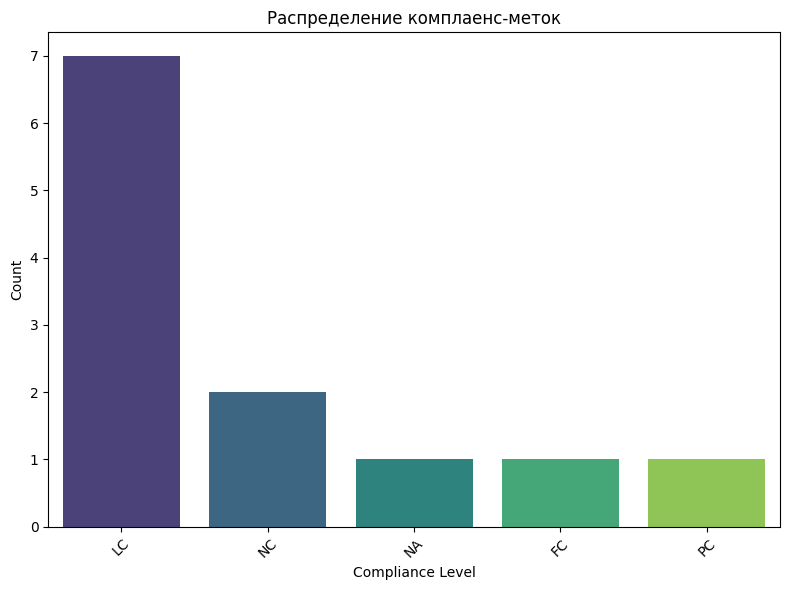

,Number,Name,Differences,Description,Complience Level
0,8800,Receiving Call Notifications,Next words are missing in UC-text:\n- [I-8800]...,Next words are missing in SSTS-text:\n Functio...,LC
1,6583,Driver initiate a call through SWP,Next words are missing in UC-text:\n- [I-6583]...,Next words are missing in SSTS-text:\n Make: 4...,NC
2,26160,Filtering the internet radio stations,Next words are missing in UC-text:\n- [I-26160...,Next words are missing in SSTS-text:\n,NA
3,31523,Adding Internet Radio to Favorites List,Next words are missing in UC-text:\n- [I-31523...,Next words are missing in SSTS-text:\n Favorit...,FC
4,26161,FM Radio Stations switching,Next words are missing in UC-text:\n- [I-26161...,Next words are missing in SSTS-text:\n Automat...,LC
5,30371,ERA Self-diagnosis,Next words are missing in UC-text:\n- [I-30371...,Next words are missing in SSTS-text:\n Functio...,LC
6,26771,Turn on and off hotspot via VA,Next words are missing in UC-text:\n- [I-26771...,Next words are missing in SSTS-text:\n Functio...,LC
7,28561,Setting Hotspot name & password,Next words are missing in UC-text:\n- [I-28561...,Next words are missing in SSTS-text:\n hotspot...,LC
8,8692,Emergency Service Communication (ERA-Glonass),Next words are missing in UC-text:\n- [I-8692]...,Next words are missing in SSTS-text:\n Manual:...,LC
9,8604,Source selection for Media output,Next words are missing in UC-text:\n- [I-8604]...,Next words are missing in SSTS-text:\n Switch:...,NC


In [8]:
report = ds[config["report_columns"]]
report["complience_level"] = preds
report["complience_level"] = (
    round(report["complience_level"])
    .astype("int16")
    .map(
        {v: k for k, v in config["target_dict"].items()}
    )
)
report = report.rename(
    columns={
        "id": "Number",
        "case_name": "Name",
        "differences": "Differences",
        "description": "Description",
        "complience_level": "Complience Level"
    }
)

logger.info(report["Complience Level"].value_counts())

report_dir = abs_path / "submissions"

report.to_csv(report_dir / "submission.csv", index=False)
plot_compliance_distribution(report, True, report_dir)
report

In [9]:
timer_val = exec_time(start_, time.time())

logger.info(f'Inference fineshed. Executed time: {timer_val}')
timer_val

2024-11-10 08:22:58,533 - __main__ - INFO - Inference fineshed. Executed time: Completed for 00:00:17


'Completed for 00:00:17'